🧠 Step 1: Loading and Structuring the SEED Dataset (DE Features - 4s)
This code cell is responsible for parsing the SEED dataset from the ExtractedFeatures_4s folder and converting it into a structured Python list of trials. Each trial includes subject metadata, emotion labels, and pooled DE features.

📥 Dataset Description
We use Differential Entropy (DE) features extracted from EEG signals with a 4-second sliding window. DE is a widely used feature in EEG-based emotion recognition because it reflects signal power across frequency bands under the assumption that EEG follows a Gaussian distribution [1].

Each .mat file corresponds to one session of a subject and contains:

15 trials (de_movingAve1 to de_movingAve15)

Each trial: shape (62 channels × time windows × 5 frequency bands)

The accompanying label.mat file provides ground-truth emotion labels at the subject level:

+1: Positive emotion

0: Neutral emotion

−1: Negative emotion

⚙️ Code Functionality
Load the subject-level emotion labels from label.mat.

Parse 45 EEG session files (15 subjects × 3 sessions).

For each trial:

Perform mean pooling across the time axis.

Flatten the resulting 2D matrix (62 × 5) into a 1D vector (310 features).

Store subject ID, session ID, trial ID, label, and DE features.

This structure facilitates subject-aware learning and helps us later in applying multi-source contrastive learning.

🎯 Motivation for Mean Pooling
Since EEG signals are highly non-stationary, pooling over the temporal axis stabilizes the input features and reduces model complexity without discarding key spectral information. This is crucial for generalization across subjects [2].

🔀 Step A: Balanced Subject Split for Training/Validation/Test
We perform a subject-level split to prevent data leakage and overfitting, ensuring that the model generalizes to unseen subjects:

Train subjects (9): IDs 7–15

Validation subjects (3): IDs 4–6 (one per class)

Test subjects (3): IDs 1–3 (one per class)

This setup enables multi-source contrastive learning (training on multiple source domains) and testing on unseen target domains, aligning with domain generalization principles [3].

Such a stratified LOSO-style split (by subject, not trial) is crucial for fair evaluation in EEG-based emotion recognition, where inter-subject variability is high.

✅ Outcome
675 trials extracted (45 sessions × 15 trials)

Each trial contains 310 DE features

Trials grouped into train/val/test for cross-subject learning

📚 References

[1] Duan, R., Zhu, J., Lu, B. L. (2013). "Differential entropy feature for EEG-based emotion classification". In 2013 6th International IEEE/EMBS Conference on Neural Engineering (NER).

[2] Li, Y., Zheng, W., & Lu, B. L. (2018). "Emotion recognition using fusion of graph CNN and LSTM networks". In Brain-Computer Interface research.

[3] Pan, S. J., & Yang, Q. (2010). "A survey on transfer learning". IEEE Transactions on Knowledge and Data Engineering.

In [1]:
import scipy.io
import os
import re
import numpy as np

DATASET_PATH = '/kaggle/input/eeg-extracted-4s/ExtractedFeatures_4s'
label_file = os.path.join(DATASET_PATH, 'label.mat')

# Load subject-level emotion labels
label_data = scipy.io.loadmat(label_file)
subject_labels = label_data['label'].flatten()  # shape: (15,)
print("✅ Subject-level labels loaded:", subject_labels)

# Load all .mat files except label
all_files = sorted([f for f in os.listdir(DATASET_PATH) if f.endswith('.mat') and f != 'label.mat'])

dataset = []

for file in all_files:
    path = os.path.join(DATASET_PATH, file)
    mat = scipy.io.loadmat(path)

    # Parse subject ID from filename
    match = re.match(r"(\d+)_(\d+)\.mat", file)
    subject_id = int(match.group(1))
    session_id = match.group(2)

    # Get subject-level emotion label
    label = int(subject_labels[subject_id - 1])  # subject IDs are 1-indexed

    # Collect 15 trials from the session
    for i in range(1, 16):
        trial_key = f"de_movingAve{i}"
        raw_de = mat[trial_key]  # shape: (62, T, 5)
        pooled = np.mean(raw_de, axis=1)  # (62, 5)
        flat = pooled.flatten()  # (310,)

        dataset.append({
            "subject": subject_id,
            "session": session_id,
            "trial_id": i - 1,
            "label": label,
            "de": flat
        })

print(f"\n✅ Loaded {len(dataset)} trials across {len(all_files)} sessions")
print("📊 Sample trial:")
for k, v in dataset[0].items():
    print(f"{k}: {v if isinstance(v, (int, str)) else v.shape}")

✅ Subject-level labels loaded: [ 1  0 -1 -1  0  1 -1  0  1  1  0 -1  0  1 -1]

✅ Loaded 675 trials across 45 sessions
📊 Sample trial:
subject: 10
session: 20131130
trial_id: 0
label: 1
de: (310,)


In [2]:
import random
from collections import defaultdict

# Reproducibility
random.seed(42)

# Extract all subject IDs from the dataset
all_subjects = sorted(list(set([sample['subject'] for sample in dataset])))
print("📋 All subjects:", all_subjects)

# Shuffle and split
random.shuffle(all_subjects)
train_subjects = all_subjects[:11]
val_subjects   = all_subjects[11:13]
test_subjects  = all_subjects[13:]

print("\n📊 Subject split:")
print("Train subjects:", train_subjects)
print("Val subjects:  ", val_subjects)
print("Test subjects: ", test_subjects)

# Now group trials based on the split
train_set = [x for x in dataset if x['subject'] in train_subjects]
val_set   = [x for x in dataset if x['subject'] in val_subjects]
test_set  = [x for x in dataset if x['subject'] in test_subjects]

print("\n✅ Trial counts:")
print("Train trials:", len(train_set))
print("Val trials:  ", len(val_set))
print("Test trials: ", len(test_set))

📋 All subjects: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

📊 Subject split:
Train subjects: [9, 14, 8, 7, 15, 13, 6, 3, 10, 4, 5]
Val subjects:   [12, 1]
Test subjects:  [2, 11]

✅ Trial counts:
Train trials: 495
Val trials:   90
Test trials:  90


In [3]:
# Custom balanced subject split (Step A)
train_subjects = [7, 8, 9, 10, 11, 12, 13, 14, 15]
val_subjects   = [4, 5, 6]     # 1x neg, 1x neutral, 1x positive
test_subjects  = [1, 2, 3]     # 1x pos, 1x neutral, 1x neg

# Now group trials based on the split
train_set = [x for x in dataset if x['subject'] in train_subjects]
val_set   = [x for x in dataset if x['subject'] in val_subjects]
test_set  = [x for x in dataset if x['subject'] in test_subjects]

print("\n✅ Balanced subject split")
print("Train subjects:", train_subjects)
print("Val subjects:  ", val_subjects)
print("Test subjects: ", test_subjects)
print("Train trials:", len(train_set))
print("Val trials:  ", len(val_set))
print("Test trials: ", len(test_set))


✅ Balanced subject split
Train subjects: [7, 8, 9, 10, 11, 12, 13, 14, 15]
Val subjects:   [4, 5, 6]
Test subjects:  [1, 2, 3]
Train trials: 405
Val trials:   135
Test trials:  135


In [4]:
import torch
from torch.utils.data import Dataset, DataLoader

class EEGTrialDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        trial = self.data[idx]
        de = torch.tensor(trial['de'], dtype=torch.float32)
        label = torch.tensor(trial['label'], dtype=torch.long)
        subject = torch.tensor(trial['subject'], dtype=torch.long)
        session = trial['session']  # Keep as string for now (if needed for analysis)
        return de, label, subject, session

In [5]:
# Create PyTorch datasets
train_dataset = EEGTrialDataset(train_set)
val_dataset   = EEGTrialDataset(val_set)
test_dataset  = EEGTrialDataset(test_set)

# Create DataLoaders
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("✅ DataLoaders created")

✅ DataLoaders created


In [6]:
# View a sample batch
sample_batch = next(iter(train_loader))
de_batch, label_batch, subject_batch, session_batch = sample_batch

print("📦 Batch shapes:")
print("DE features:", de_batch.shape)
print("Labels:     ", label_batch.shape)
print("Subjects:   ", subject_batch.shape)
print("Sessions:   ", session_batch[:3])  # just show a few

📦 Batch shapes:
DE features: torch.Size([64, 310])
Labels:      torch.Size([64])
Subjects:    torch.Size([64])
Sessions:    ('20140704', '20140630', '20140511')


In [7]:
import torch.nn as nn
import torch.nn.functional as F

class DEEncoder(nn.Module):
    def __init__(self, input_dim=310, hidden_dim=128, projection_dim=64):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim)
        )
        self.projection = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, projection_dim)
        )

    def forward(self, x):
        h = self.encoder(x)         # Representation
        z = self.projection(h)      # Projection head
        z = F.normalize(z, dim=1)   # L2 normalize for contrastive loss
        return h, z

In [8]:
# Instantiate model and push to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DEEncoder().to(device)

# Get a sample batch
de_batch, label_batch, subject_batch, session_batch = next(iter(train_loader))
de_batch = de_batch.to(device)

# Forward pass
h_batch, z_batch = model(de_batch)

print("✅ Forward pass complete:")
print("Representation shape:", h_batch.shape)
print("Projected embedding shape:", z_batch.shape)

✅ Forward pass complete:
Representation shape: torch.Size([64, 128])
Projected embedding shape: torch.Size([64, 64])


In [9]:
class SupConLoss(nn.Module):
    def __init__(self, temperature=0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        """
        features: (batch_size, projection_dim) → L2-normalized
        labels:   (batch_size,) → int
        """
        device = features.device
        batch_size = features.shape[0]

        # Cosine similarity matrix: (B, B)
        sim_matrix = torch.div(
            torch.matmul(features, features.T), self.temperature
        )

        # Mask to exclude self-similarity
        mask = torch.eye(batch_size, dtype=torch.bool).to(device)
        sim_matrix.masked_fill_(mask, -1e9)

        labels = labels.contiguous().view(-1, 1)
        match_mask = torch.eq(labels, labels.T).float().to(device)
        
        # ⛔ Remove self-comparisons from the match mask
        mask = torch.eye(batch_size, dtype=torch.bool).to(device)
        match_mask = match_mask.masked_fill(mask, 0)  # Zero out the diagonal

        # For each anchor, compute denominator over all other samples
        exp_sim = torch.exp(sim_matrix)
        log_prob = sim_matrix - torch.log(exp_sim.sum(dim=1, keepdim=True) + 1e-9)

        # Apply supervised mask to get positives only
        mean_log_prob_pos = (match_mask * log_prob).sum(1) / match_mask.sum(1).clamp(min=1)

        # Final loss
        loss = -mean_log_prob_pos.mean()

        return loss

In [10]:
# Prepare batch on GPU
label_batch = label_batch.to(device)

# Compute SupCon Loss
criterion = SupConLoss(temperature=0.07)
loss = criterion(z_batch, label_batch)

print("✅ Contrastive loss:", loss.item())

✅ Contrastive loss: 9.966450691223145


In [11]:
from tqdm import tqdm

def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0

    for de, labels, _, _ in tqdm(dataloader, desc="🟢 Training"):
        de = de.to(device)
        labels = labels.to(device)

        _, embeddings = model(de)
        loss = criterion(embeddings, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(dataloader)
    return avg_loss


def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0

    with torch.no_grad():
        for de, labels, _, _ in dataloader:
            de = de.to(device)
            labels = labels.to(device)

            _, embeddings = model(de)
            loss = criterion(embeddings, labels)

            total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    return avg_loss

In [12]:
# Model & loss (already defined)
model = DEEncoder().to(device)
criterion = SupConLoss(temperature=0.07)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training parameters
epochs = 10

train_losses = []
val_losses = []

for epoch in range(1, epochs + 1):
    print(f"\n📦 Epoch {epoch}/{epochs}")
    
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss = validate(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"✅ Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")


📦 Epoch 1/10


🟢 Training: 100%|██████████| 7/7 [00:00<00:00, 34.67it/s]


✅ Train Loss: 7.9995 | Val Loss: 3.3318

📦 Epoch 2/10


🟢 Training: 100%|██████████| 7/7 [00:00<00:00, 246.79it/s]


✅ Train Loss: 5.1351 | Val Loss: 3.3186

📦 Epoch 3/10


🟢 Training: 100%|██████████| 7/7 [00:00<00:00, 250.15it/s]


✅ Train Loss: 4.0360 | Val Loss: 3.2809

📦 Epoch 4/10


🟢 Training: 100%|██████████| 7/7 [00:00<00:00, 249.00it/s]


✅ Train Loss: 3.3123 | Val Loss: 3.2974

📦 Epoch 5/10


🟢 Training: 100%|██████████| 7/7 [00:00<00:00, 258.31it/s]


✅ Train Loss: 3.2501 | Val Loss: 3.2760

📦 Epoch 6/10


🟢 Training: 100%|██████████| 7/7 [00:00<00:00, 252.27it/s]


✅ Train Loss: 3.0815 | Val Loss: 3.2940

📦 Epoch 7/10


🟢 Training: 100%|██████████| 7/7 [00:00<00:00, 198.10it/s]


✅ Train Loss: 2.9808 | Val Loss: 3.4886

📦 Epoch 8/10


🟢 Training: 100%|██████████| 7/7 [00:00<00:00, 229.40it/s]


✅ Train Loss: 2.9949 | Val Loss: 3.2596

📦 Epoch 9/10


🟢 Training: 100%|██████████| 7/7 [00:00<00:00, 246.03it/s]


✅ Train Loss: 2.9390 | Val Loss: 4.5841

📦 Epoch 10/10


🟢 Training: 100%|██████████| 7/7 [00:00<00:00, 217.67it/s]


✅ Train Loss: 3.2859 | Val Loss: 3.3114


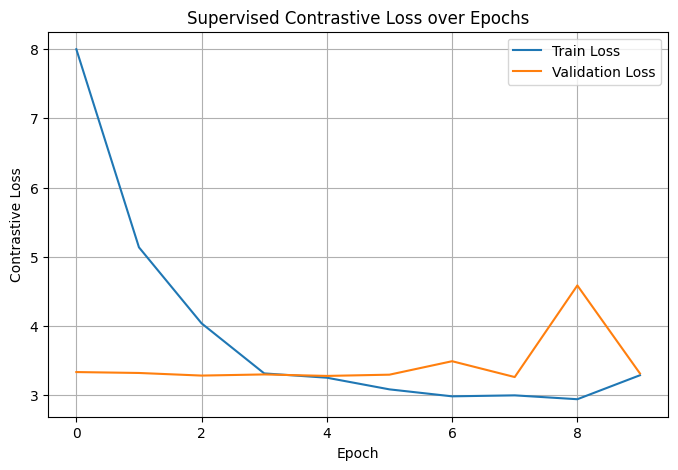

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Contrastive Loss")
plt.title("Supervised Contrastive Loss over Epochs")
plt.legend()
plt.grid(True)
plt.show()

In [14]:
torch.manual_seed(42)
np.random.seed(42)

In [15]:
def extract_encoder(model: DEEncoder):
    encoder_only = nn.Sequential(*list(model.encoder)).to(device)
    for param in encoder_only.parameters():
        param.requires_grad = False
    return encoder_only

In [16]:
frozen_encoder = extract_encoder(model)

In [17]:
def extract_features(dataloader, encoder, device):
    encoder.eval()
    features, labels = [], []

    with torch.no_grad():
        for de, label, _, _ in dataloader:
            de = de.to(device)
            h = encoder(de)  # shape: (B, 128)
            features.append(h.cpu())
            labels.append(label)

    X = torch.cat(features, dim=0)
    y = torch.cat(labels, dim=0)
    return X, y

X_train, y_train = extract_features(train_loader, frozen_encoder, device)
X_val, y_val     = extract_features(val_loader, frozen_encoder, device)
X_test, y_test   = extract_features(test_loader, frozen_encoder, device)

In [18]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# X_train = torch.tensor(scaler.fit_transform(X_train), dtype=torch.float32)
# X_val   = torch.tensor(scaler.transform(X_val), dtype=torch.float32)
# X_test  = torch.tensor(scaler.transform(X_test), dtype=torch.float32)

X_train = X_train.float()
X_val   = X_val.float()
X_test  = X_test.float()

In [19]:
# Remap labels: -1 → 0, 0 → 1, 1 → 2
def remap_labels(y):
    return torch.where(y == -1, 0, torch.where(y == 0, 1, 2))

y_train = remap_labels(y_train)
y_val   = remap_labels(y_val)
y_test  = remap_labels(y_test)

In [20]:
from sklearn.utils.class_weight import compute_class_weight

# y_train is in remapped format: 0 = neg, 1 = neutral, 2 = positive
class_weights = compute_class_weight(class_weight='balanced', classes=[0,1,2], y=y_train.numpy())
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

criterion_ce = nn.CrossEntropyLoss(weight=class_weights)


In [21]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim=128, hidden_dim=64, num_classes=3):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, num_classes)

        # ✅ Weight initialization for output layer
        nn.init.xavier_uniform_(self.fc2.weight)
        self.fc2.bias.data.fill_(0.0)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        return self.fc2(x)

In [22]:
import torch.nn as nn
import torch.nn.functional as F

class GeneralizedCrossEntropy(nn.Module):
    def __init__(self, q=0.7):
        super().__init__()
        self.q = q
        assert 0 < q <= 1, "q should be in (0, 1]"

    def forward(self, logits, targets):
        probs = F.softmax(logits, dim=1)  # shape: (batch_size, num_classes)
        probs_true = probs[range(logits.size(0)), targets]  # shape: (batch_size,)
        loss = (1 - probs_true.pow(self.q)) / self.q
        return loss.mean()


In [23]:
clf = MLPClassifier().to(device)

# Optional: you can re-include class weights here if desired
criterion_ce = GeneralizedCrossEntropy(q=0.7)
optimizer_clf = torch.optim.Adam(clf.parameters(), lr=5e-4)

epochs = 60
for epoch in range(1, epochs + 1):
    clf.train()
    logits = clf(X_train.to(device))
    loss = criterion_ce(logits, y_train.to(device))

    optimizer_clf.zero_grad()
    loss.backward()
    optimizer_clf.step()

    # Validation
    clf.eval()
    with torch.no_grad():
        val_logits = clf(X_val.to(device))
        val_preds = torch.argmax(val_logits, dim=1)
        val_acc = (val_preds == y_val.to(device)).float().mean().item()

    print(f"📦 Epoch {epoch} - Train Loss: {loss.item():.4f} | Val Acc: {val_acc:.4f}")

📦 Epoch 1 - Train Loss: 0.8053 | Val Acc: 0.4741
📦 Epoch 2 - Train Loss: 0.7903 | Val Acc: 0.5259
📦 Epoch 3 - Train Loss: 0.7753 | Val Acc: 0.6000
📦 Epoch 4 - Train Loss: 0.7603 | Val Acc: 0.5852
📦 Epoch 5 - Train Loss: 0.7455 | Val Acc: 0.5407
📦 Epoch 6 - Train Loss: 0.7308 | Val Acc: 0.4593
📦 Epoch 7 - Train Loss: 0.7165 | Val Acc: 0.3778
📦 Epoch 8 - Train Loss: 0.7026 | Val Acc: 0.3407
📦 Epoch 9 - Train Loss: 0.6893 | Val Acc: 0.3407
📦 Epoch 10 - Train Loss: 0.6765 | Val Acc: 0.3333
📦 Epoch 11 - Train Loss: 0.6644 | Val Acc: 0.3333
📦 Epoch 12 - Train Loss: 0.6528 | Val Acc: 0.3333
📦 Epoch 13 - Train Loss: 0.6418 | Val Acc: 0.3333
📦 Epoch 14 - Train Loss: 0.6314 | Val Acc: 0.3333
📦 Epoch 15 - Train Loss: 0.6213 | Val Acc: 0.3333
📦 Epoch 16 - Train Loss: 0.6117 | Val Acc: 0.3333
📦 Epoch 17 - Train Loss: 0.6023 | Val Acc: 0.3333
📦 Epoch 18 - Train Loss: 0.5932 | Val Acc: 0.3333
📦 Epoch 19 - Train Loss: 0.5843 | Val Acc: 0.3333
📦 Epoch 20 - Train Loss: 0.5754 | Val Acc: 0.3333
📦 Epoch 2

In [24]:
label_names = { -1: "Negative", 0: "Neutral", 1: "Positive" }
colors = { -1: 'red', 0: 'gray', 1: 'green' }

In [25]:
# Extract frozen features
X_test, y_test_original = extract_features(test_loader, frozen_encoder, device)

# Save this version for t-SNE
# Don't modify it yet

# Now remap only for classifier
def remap_labels(y):
    return torch.where(y == -1, 0, torch.where(y == 0, 1, 2))

y_test = remap_labels(y_test_original)

🔍 Running t-SNE...


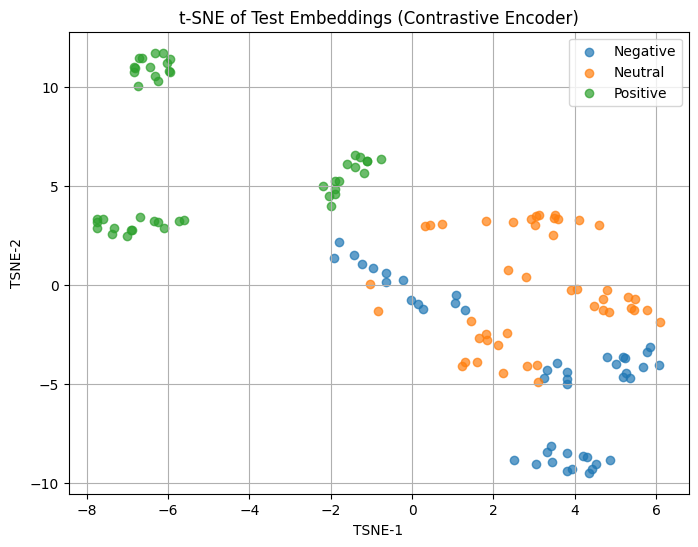

In [26]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Convert to numpy
X_np = X_test.numpy()
y_np = y_test_original.numpy()

# Fit t-SNE
print("🔍 Running t-SNE...")
tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto', init='pca', random_state=42)
X_2d = tsne.fit_transform(X_np)

# Plot
plt.figure(figsize=(8, 6))

for label in np.unique(y_np):
    idx = y_np == label
    plt.scatter(X_2d[idx, 0], X_2d[idx, 1], label=label_names[label], alpha=0.7)

plt.title("t-SNE of Test Embeddings (Contrastive Encoder)")
plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.legend()
plt.grid(True)
plt.show()

In [27]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Predict on test set
clf.eval()
with torch.no_grad():
    test_logits = clf(X_test.to(device))
    y_pred = torch.argmax(test_logits, dim=1).cpu().numpy()
    y_true = y_test.cpu().numpy()  # these are remapped: 0 = neg, 1 = neu, 2 = pos

In [28]:
from sklearn.metrics import accuracy_score

print("✅ Test Accuracy:", accuracy_score(y_true, y_pred) * 100, "%")
print("\n📄 Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Negative", "Neutral", "Positive"]))

✅ Test Accuracy: 48.888888888888886 %

📄 Classification Report:
              precision    recall  f1-score   support

    Negative       0.86      0.13      0.23        45
     Neutral       0.31      0.33      0.32        45
    Positive       0.56      1.00      0.72        45

    accuracy                           0.49       135
   macro avg       0.58      0.49      0.42       135
weighted avg       0.58      0.49      0.42       135



/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


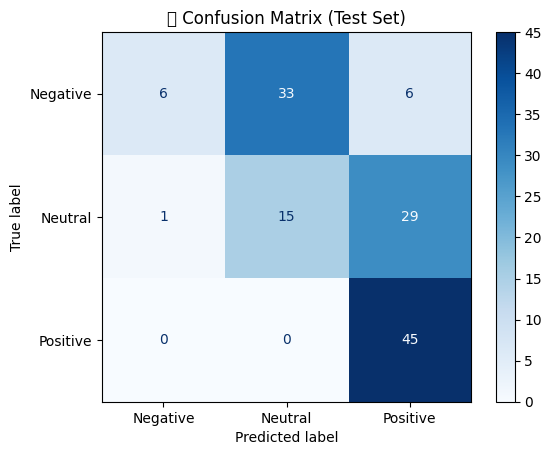

In [29]:
disp = ConfusionMatrixDisplay.from_predictions(
    y_true, y_pred,
    display_labels=["Negative", "Neutral", "Positive"],
    cmap="Blues",
    normalize=None
)
disp.ax_.set_title("🧠 Confusion Matrix (Test Set)")
plt.show()

22/4

“Fine-tuning after supervised contrastive pretraining improves downstream task accuracy by aligning learned representations with task-specific decision boundaries.”
— Khosla et al., 2020, Supervised Contrastive Learning [[paper link](https://arxiv.org/abs/2004.11362)]

In [30]:
class FullFineTuneModel(nn.Module):
    def __init__(self, encoder, classifier):
        super().__init__()
        self.encoder = encoder
        self.classifier = classifier

    def forward(self, x):
        h = self.encoder(x)
        out = self.classifier(h)
        return out

# Make encoder trainable
for param in model.encoder.parameters():
    param.requires_grad = True

full_model = FullFineTuneModel(model.encoder, clf).to(device)

criterion_ft = GeneralizedCrossEntropy(q=0.7)
optimizer_ft = torch.optim.Adam(full_model.parameters(), lr=5e-4)

In [31]:
epochs = 60

for epoch in range(1, epochs + 1):
    full_model.train()
    running_loss = 0.0
    for de, label, _, _ in train_loader:
        de = de.to(device)
        label = label.to(device)

        logits = full_model(de)
        loss = criterion_ft(logits, label)

        optimizer_ft.zero_grad()
        loss.backward()
        optimizer_ft.step()

        running_loss += loss.item()
    
    train_loss = running_loss / len(train_loader)

    # Validation
    full_model.eval()
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        for de, label, _, _ in val_loader:
            de = de.to(device)
            label = label.to(device)

            val_logits = full_model(de)
            preds = torch.argmax(val_logits, dim=1)
            total_correct += (preds == label).sum().item()
            total_samples += label.size(0)

    val_acc = total_correct / total_samples
    print(f"📦 Epoch {epoch} - Fine-tune Loss: {train_loss:.4f} | Val Acc: {val_acc:.4f}")


📦 Epoch 1 - Fine-tune Loss: 0.9003 | Val Acc: 0.0000
📦 Epoch 2 - Fine-tune Loss: 0.6836 | Val Acc: 0.0000
📦 Epoch 3 - Fine-tune Loss: 0.5387 | Val Acc: 0.0296
📦 Epoch 4 - Fine-tune Loss: 0.4239 | Val Acc: 0.3333
📦 Epoch 5 - Fine-tune Loss: 0.3448 | Val Acc: 0.3333
📦 Epoch 6 - Fine-tune Loss: 0.2959 | Val Acc: 0.3333
📦 Epoch 7 - Fine-tune Loss: 0.2335 | Val Acc: 0.3333
📦 Epoch 8 - Fine-tune Loss: 0.2035 | Val Acc: 0.3333
📦 Epoch 9 - Fine-tune Loss: 0.1470 | Val Acc: 0.4148
📦 Epoch 10 - Fine-tune Loss: 0.1117 | Val Acc: 0.3333
📦 Epoch 11 - Fine-tune Loss: 0.0953 | Val Acc: 0.4667
📦 Epoch 12 - Fine-tune Loss: 0.0811 | Val Acc: 0.5037
📦 Epoch 13 - Fine-tune Loss: 0.0753 | Val Acc: 0.5481
📦 Epoch 14 - Fine-tune Loss: 0.0561 | Val Acc: 0.4963
📦 Epoch 15 - Fine-tune Loss: 0.0525 | Val Acc: 0.4963
📦 Epoch 16 - Fine-tune Loss: 0.0540 | Val Acc: 0.5185
📦 Epoch 17 - Fine-tune Loss: 0.0411 | Val Acc: 0.4963
📦 Epoch 18 - Fine-tune Loss: 0.0329 | Val Acc: 0.3778
📦 Epoch 19 - Fine-tune Loss: 0.0305 |

In [32]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

y_true = []
y_pred = []

full_model.eval()
with torch.no_grad():
    for de, label, _, _ in test_loader:
        de = de.to(device)
        label = label.to(device)
        output = full_model(de)
        preds = torch.argmax(output, dim=1)
        y_pred.extend(preds.cpu().numpy())
        y_true.extend(label.cpu().numpy())

print("✅ Fine-Tuned Test Accuracy:", accuracy_score(y_true, y_pred) * 100, "%")

✅ Fine-Tuned Test Accuracy: 34.074074074074076 %


In [33]:
def remap_labels(y):
    return torch.where(y == -1, 0, torch.where(y == 0, 1, 2))

y_true = remap_labels(torch.tensor(y_true)).numpy()
y_pred = remap_labels(torch.tensor(y_pred)).numpy()


📄 Classification Report:
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00        45
     Neutral       0.06      0.02      0.03        45
    Positive       0.38      1.00      0.55        45

    accuracy                           0.34       135
   macro avg       0.15      0.34      0.19       135
weighted avg       0.15      0.34      0.19       135



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.

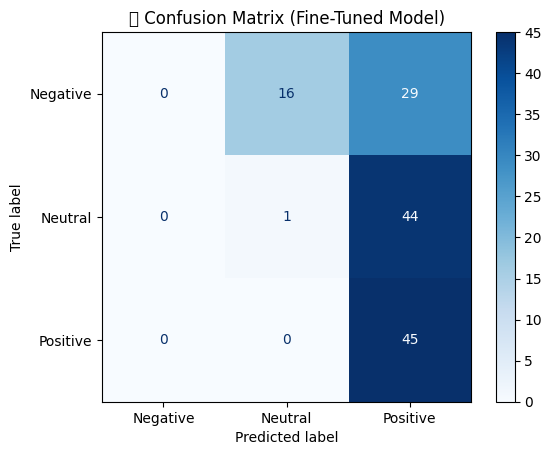

In [34]:
print("\n📄 Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Negative", "Neutral", "Positive"]))

ConfusionMatrixDisplay.from_predictions(
    y_true, y_pred,
    display_labels=["Negative", "Neutral", "Positive"],
    cmap="Blues"
)
plt.title("🧠 Confusion Matrix (Fine-Tuned Model)")
plt.show()

In [35]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Store features and true labels
features = []
labels = []

full_model.eval()
with torch.no_grad():
    for de, label, _, _ in test_loader:
        de = de.to(device)
        h = full_model.encoder(de)  # shape: [batch, 128]
        features.append(h.cpu())
        labels.append(label)

X_tsne = torch.cat(features, dim=0).numpy()
y_tsne = torch.cat(labels, dim=0).numpy()

# Remap if needed
y_tsne = remap_labels(torch.tensor(y_tsne)).numpy()


🔍 Running t-SNE...


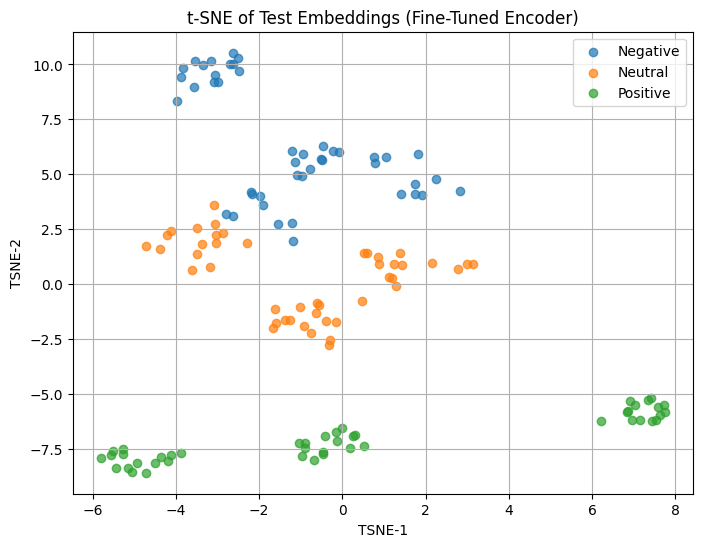

In [36]:
print("🔍 Running t-SNE...")
tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto', init='pca', random_state=42)
X_2d = tsne.fit_transform(X_tsne)

label_names = ["Negative", "Neutral", "Positive"]
colors = ["red", "gray", "green"]

plt.figure(figsize=(8, 6))
for class_idx in np.unique(y_tsne):
    idx = y_tsne == class_idx
    plt.scatter(X_2d[idx, 0], X_2d[idx, 1], label=label_names[class_idx], alpha=0.7)

plt.title("t-SNE of Test Embeddings (Fine-Tuned Encoder)")
plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.legend()
plt.grid(True)
plt.show()

In [37]:
import scipy.io

# Replace this path with your actual .mat file path
file_path = "/kaggle/input/eeg-extracted-4s/ExtractedFeatures_4s/12_20131127.mat"

# Load .mat file
mat_data = scipy.io.loadmat(file_path)

# Print all keys and shapes
print(f"✅ Keys in {file_path}:")
for key in mat_data:
    if not key.startswith('__'):  # Skip metadata keys
        value = mat_data[key]
        print(f"{key}: shape = {value.shape} | type = {type(value)}")
        # Optional preview:
        if hasattr(value, 'shape') and len(value.shape) > 0 and value.size < 100:
            print("Preview:", value)


✅ Keys in /kaggle/input/eeg-extracted-4s/ExtractedFeatures_4s/12_20131127.mat:
de_movingAve1: shape = (62, 58, 5) | type = <class 'numpy.ndarray'>
de_LDS1: shape = (62, 58, 5) | type = <class 'numpy.ndarray'>
psd_movingAve1: shape = (62, 58, 5) | type = <class 'numpy.ndarray'>
psd_LDS1: shape = (62, 58, 5) | type = <class 'numpy.ndarray'>
de_movingAve2: shape = (62, 58, 5) | type = <class 'numpy.ndarray'>
de_LDS2: shape = (62, 58, 5) | type = <class 'numpy.ndarray'>
psd_movingAve2: shape = (62, 58, 5) | type = <class 'numpy.ndarray'>
psd_LDS2: shape = (62, 58, 5) | type = <class 'numpy.ndarray'>
de_movingAve3: shape = (62, 51, 5) | type = <class 'numpy.ndarray'>
de_LDS3: shape = (62, 51, 5) | type = <class 'numpy.ndarray'>
psd_movingAve3: shape = (62, 51, 5) | type = <class 'numpy.ndarray'>
psd_LDS3: shape = (62, 51, 5) | type = <class 'numpy.ndarray'>
de_movingAve4: shape = (62, 59, 5) | type = <class 'numpy.ndarray'>
de_LDS4: shape = (62, 59, 5) | type = <class 'numpy.ndarray'>
psd_m